# FRED Data explorer

For quick exploration of FRED database

In [1]:
from fredapi import Fred
import pandas as pd
pd.options.display.max_colwidth = 130

import numpy as np
from dateutil import relativedelta as rd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fred = Fred(api_key_file= '/home/alex/alex/projects/datascienceprojects/apis/fredapikey.txt')

## Search FRED database

In [3]:
fred.search("payems").T

series id,PAYEMS,PAYNSA
frequency,Monthly,Monthly
frequency_short,M,M
id,PAYEMS,PAYNSA
last_updated,2019-11-01 15:05:01,2019-11-01 15:05:02
notes,"All Employees: Total Nonfarm, commonly known as Total Nonfarm Payroll, is a measure of the number of U.S. workers in the econo...","All Employees: Total Nonfarm, commonly known as Total Nonfarm Payroll, is a measure of the number of U.S. workers in the econo..."
observation_end,2019-10-01 00:00:00,2019-10-01 00:00:00
observation_start,1939-01-01 00:00:00,1939-01-01 00:00:00
popularity,84,56
realtime_end,2019-11-18 00:00:00,2019-11-18 00:00:00
realtime_start,2019-11-18 00:00:00,2019-11-18 00:00:00


# Annex - how fred works!

## 

In [23]:
nfp_total = fred.get_series('payems')
nfp_total.tail()

2019-06-01    151252.0
2019-07-01    151418.0
2019-08-01    151637.0
2019-09-01    151817.0
2019-10-01    151945.0
dtype: float64

## get_series_first_release()

Several options. `get_series_first_release` returns the data as first released

In [4]:
nfp_first = fred.get_series_first_release('payems')

In [5]:
nfp_first.tail()

date
2019-06-01    151308
2019-07-01    151431
2019-08-01    151541
2019-09-01    151722
2019-10-01    151945
Name: value, dtype: object

## get_series_vintage_dates()

Get a list of vintage dates for a series. Vintage dates are the dates in history when a
series' data values were revised or new data values were released.

* This section finishes with the creation of a dataframe which associates a datapoint date e.g. 2019-01-01 with a release date e.g. 2019-02-03. There is actually a better way of doing this via get_series_all_releases() so it is irrelevant!

In [6]:
nfp_vintage_dates = fred.get_series_vintage_dates('payems')

In [7]:
nfp_vintage_dates[0:4]

[datetime.datetime(1955, 5, 6, 0, 0),
 datetime.datetime(1955, 6, 7, 0, 0),
 datetime.datetime(1955, 7, 8, 0, 0),
 datetime.datetime(1955, 8, 9, 0, 0)]

The vintage_dates data doesn't seem to be perfect. To check, I created a DataFrame with number of observations per calendar year for first_release and vintage_dates. You can see in chart below that there were two years when vintage_dates had 13 instead of 12 observations.

In [8]:
years = pd.DatetimeIndex(nfp_vintage_dates).year
unique_years, counts = np.unique(years, return_counts=True)
# year_count = [{ "year": year, "count": count } for year, count in zip(unique_years, counts)]

years_first = nfp_first.index.year
unique_years_first, counts_first = np.unique(years_first, return_counts=True)
# year_count_first = [{ "year": year, "count": count } for year, count in zip(unique_years_first, counts_first)]

yearly_obs = pd.DataFrame(counts, index = unique_years, columns = ['vintage_count'])
yearly_obs_first = pd.DataFrame(counts_first, index = unique_years_first, columns = ['first_count'])
yearly_obs = pd.merge(yearly_obs, yearly_obs_first, left_index = True, right_index=True)


[]

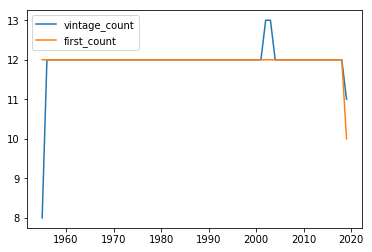

In [9]:
fig = plt.figure()

plt.plot(yearly_obs)
plt.legend(yearly_obs.columns)

plt.plot()

To deal with this problem, I converted the vintage_dates list in to a DataFrame and then created a boolean mask to slice the DataFrame using iloc. I just assumed that the first vintage_date in the month was the correct one. It's only an issue for two dates - one in 2002 and one in 2003.

In [11]:
i = 1
# dtype = bool converts and np.ones or np.zeros array into boolean array
mask = np.ones(len(nfp_vintage_dates), dtype = bool)
while i < len(nfp_vintage_dates) - 1:
#    print(nfp_vintage_dates[i].month, end=', ')
    if (nfp_vintage_dates[i].month == nfp_vintage_dates[i-1].month and
        (nfp_vintage_dates[i]+ rd.relativedelta(months=+1)).month == nfp_vintage_dates[i+1].month) : 
        mask[i] = False
    i = i + 1


In [12]:
vintage_dates_df = pd.DataFrame(index = nfp_vintage_dates)
# vintage_dates_df.loc['2002-1-1':'2003-12-30']

In [13]:
vintage_dates_df = vintage_dates_df.iloc[mask]

### Create a DataFrame that associates a vintage_date with the payrolls date. 

Index is month-year and column is the actual release date associated with that observation.

In [14]:
# First slice the nfp_first DataFrame so that first datapoint corresponds to first
# datapoint in vintage_dates
nfp_first = nfp_first[nfp_first.index >= pd.datetime(1955, 4, 1)]

vintage_dates = pd.DataFrame(data = vintage_dates_df.index, 
                             index = nfp_first.index, 
                             columns = ['vintage_dates'])

vintage_dates.tail()


,vintage_dates
date,
2019-06-01,2019-07-05
2019-07-01,2019-08-02
2019-08-01,2019-09-06
2019-09-01,2019-10-04
2019-10-01,2019-11-01


## get_series_all_releases()

Get all data for a Fred series id including first releases and all revisions. This returns a DataFrame
with three columns: 'date', 'realtime_start', and 'value'. For instance, the US GDP for Q4 2013 was first released
to be 17102.5 on 2014-01-30, and then revised to 17080.7 on 2014-02-28, and then revised to 17089.6 on
2014-03-27. You will therefore get three rows with the same 'date' (observation date) of 2013-10-01 but three
different 'realtime_start' of 2014-01-30, 2014-02-28, and 2014-03-27 with corresponding 'value' of 17102.5, 17080.7
and 17089.6

### Challenges of recreating change in NFP

It is easy to recreate the official change in NFP data: just take the difference between successive final release data from FRED. I'm finding it much more complicated to recreate the change in NFP as reported on the day. Linked to this is other data reported on the day like net revisions. 

There are quite a lot of working below as I try to figure out the best way of reshaping the data to help solve the problem.

Really useful tools are:

* [pivot(), stack() and unstack()](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html) which are all helpful for reshaping single or multiindex DataFrames. I ended up using stack and unstack but pivot looks really useful.
* [MultiIndex documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html) including detail on creating MultiIndex objects with product and from tuples. Also `sortindex()` - important to do before working with data in many situations. Using slicers. E.g. `df.loc[slice(A, B, ),...],)` is the way to effectively slice the data on different levels of the index. `swaplevel()` swaps index levels and is used below.
* [groupby()](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) splits dataframe into groups and then can be used to apply functions to those groups. Used below to count how many data revisions there have been to each NFP datapoint.

In [15]:
nfp_all_releases = fred.get_series_all_releases('payems')
nfp_all_releases.tail(10)

,date,realtime_start,value
11755,2019-06-01 00:00:00,2019-09-06 00:00:00,151252
11756,2019-07-01 00:00:00,2019-08-02 00:00:00,151431
11757,2019-07-01 00:00:00,2019-09-06 00:00:00,151411
11758,2019-07-01 00:00:00,2019-10-04 00:00:00,151418
11759,2019-08-01 00:00:00,2019-09-06 00:00:00,151541
11760,2019-08-01 00:00:00,2019-10-04 00:00:00,151586
11761,2019-08-01 00:00:00,2019-11-01 00:00:00,151637
11762,2019-09-01 00:00:00,2019-10-04 00:00:00,151722
11763,2019-09-01 00:00:00,2019-11-01 00:00:00,151817
11764,2019-10-01 00:00:00,2019-11-01 00:00:00,151945


Over time, NFP data are revised many times. E.g. the Jan 1950 value has been revised 8 times:

In [16]:
nfp_all_releases[nfp_all_releases['date'] == pd.datetime(1950,1,1)]

,date,realtime_start,value
937,1950-01-01 00:00:00,1961-11-03 00:00:00,43519
938,1950-01-01 00:00:00,1963-09-06 00:00:00,43480
939,1950-01-01 00:00:00,1964-12-04 00:00:00,43467
940,1950-01-01 00:00:00,1978-10-06 00:00:00,43472
941,1950-01-01 00:00:00,1994-06-03 00:00:00,43469
942,1950-01-01 00:00:00,2003-06-06 00:00:00,43530
943,1950-01-01 00:00:00,2014-02-07 00:00:00,43528
944,1950-01-01 00:00:00,2019-02-01 00:00:00,43526


Many data points have been revised 15 times, with the maximum revisions being 20.

20


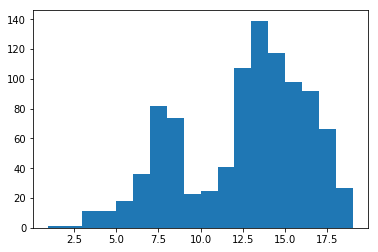

In [17]:
unique_months, count = np.unique(nfp_all_releases['date'], return_counts = True)


print(np.amax(count))
plt.figure(facecolor='w')

plt.hist(count,bins = range(1,20,1))
plt.show()

### Transform data into MultiIndex Dataframe for ease of use

First use .apply() and lambda function to create an index of release dates with 0 corresponding to first release, 1 second releast etc

In [18]:
def int_index(df):
    # create column with number of data revisions
    df['revisions'] = len(df)
    # reindex to integers
    df.index = list(range(0,len(df)))         
    df.index.name = 'release no'
    return df

NFP_total = nfp_all_releases.groupby('date').apply(int_index)
NFP_total.drop('date',axis=1,inplace=True)
NFP_total = NFP_total.unstack('release no').swaplevel(i=0,j=1,axis=1)
NFP_total.sort_index(axis = 1, inplace = True)

NFP_total.tail()

release no                   0                                      1   \
                 realtime_start revisions   value       realtime_start   
date                                                                     
2019-06-01  2019-07-05 00:00:00       3.0  151308  2019-08-02 00:00:00   
2019-07-01  2019-08-02 00:00:00       3.0  151431  2019-09-06 00:00:00   
2019-08-01  2019-09-06 00:00:00       3.0  151541  2019-10-04 00:00:00   
2019-09-01  2019-10-04 00:00:00       2.0  151722  2019-11-01 00:00:00   
2019-10-01  2019-11-01 00:00:00       1.0  151945                  NaN   

release no                                     2                     \
           revisions   value       realtime_start revisions   value   
date                                                                  
2019-06-01       3.0  151267  2019-09-06 00:00:00       3.0  151252   
2019-07-01       3.0  151411  2019-10-04 00:00:00       3.0  151418   
2019-08-01       3.0  151586  2019-11-01 00:00:00       3.0  151637   
2019-09-01       2.0  151817                  NaN       NaN     NaN   
2019-10-01       NaN     NaN                  NaN       NaN     NaN   

release no             3   ...     16             17                  \
           realtime_start  ...  value realtime_start revisions value   
date                       ...                                         
2019-06-01            NaN  ...    NaN            NaN       NaN   NaN   
2019-07-01            NaN  ...    NaN            NaN       NaN   NaN   
2019-08-01            NaN  ...    NaN            NaN       NaN   NaN   
2019-09-01            NaN  ...    NaN            NaN       NaN   NaN   
2019-10-01            NaN  ...    NaN            NaN       NaN   NaN   

release no             18                             19                  
           realtime_start revisions value realtime_start revisions value  
date                                                                      
2019-06-01            NaN       NaN   NaN            NaN       NaN   NaN  
2019-07-01            NaN       NaN   NaN            NaN       NaN   NaN  
2019-08-01            NaN       NaN   NaN            NaN       NaN   NaN  
2019-09-01            NaN       NaN   NaN            NaN       NaN   NaN  
2019-10-01            NaN       NaN   NaN            NaN       NaN   NaN  

[5 rows x 60 columns]

In [19]:
NFP_change = pd.DataFrame(index = NFP_total.index)
NFP_change['change'] = NFP_total.loc[:,(0,'value')] - NFP_total.loc[:,(1,'value')].shift(1)
NFP_change['change2'] = NFP_total.loc[:,(1,'value')] - NFP_total.loc[:,(2,'value')].shift(1)
NFP_change['change3'] = NFP_total.loc[:,(2,'value')] - NFP_total.loc[:,(2,'value')].shift(1)

NFP_change.tail()

,change,change2,change3
date,,,
2019-06-01,224,193,178
2019-07-01,164,159,166
2019-08-01,130,168,219
2019-09-01,136,180,NaN
2019-10-01,128,NaN,NaN


## Alternative method for generating change in NFP - with less reshaping of the data

The method below doesn't create the NFP_total DataFrame. It instead accesses the nth or nth-last data releases directly from the original nfp_all_releases dataframe using groupby().apply()

Exploratory functions

In [20]:
# size() gives DataFrame output
nfp_all_releases.groupby('date').size().tail()
# count() gives DataFrame output with all original columns have a count value
# nfp_all_releases.groupby('date').count().tail(10)

date
2019-06-01    3
2019-07-01    3
2019-08-01    3
2019-09-01    2
2019-10-01    1
dtype: int64

### Best way for calculating NFP change data

Uses a function and `groupby()` to iterate through the NFP data and get the data of interest. Can then perfom simple calcs (like take differences) at the next step

In [21]:
def release_n(df, revisions=[0], revs_from_last=[0]):
    #create a revs list. This concatenates the input data and converts the "revs from last"
    #integers into the "revs from first" - so same basis as the revisions list
    revs = revisions + revs_from_last
    # create column names for the output DataFrame
    cols = ['e']*len(revs)
    for n, i in enumerate(revisions):
        cols[n] = f'rev_{i}'
        revs[n] = min(i, len(df)-1)
    for n, i in enumerate(revs_from_last):
        revs[n + len(revisions)] = max(0, len(df) - 1 - i)
        cols[n + len(revisions)] = f'rev_{i}th_last'
    # create output DataFrame
    
    columns = [['releases']+['values']*len(revs)+
                ['release_dates']*len(revs)+
                ['[CHECK!]_release_no']*len(revs),
                ['releases']+cols*3
              ]
    df_out = pd.DataFrame(np.zeros((1,1 + len(revs)*3)), columns = columns)
    df_out[('releases','releases')] = len(df)
    # Populate columns in output DataFrame - both release value and release date
    for n, i in enumerate(revs):
        if n==0 or i > revs[n-1]:
            df_out[('values',cols[n])] = df['value'].iloc[i]
            df_out[('release_dates',cols[n])] = df['realtime_start'].iloc[i]
            df_out[('[CHECK!]_release_no',cols[n])] = i + 1
        else:
            df_out[('values',cols[n])] = np.nan
            df_out[('release_dates',cols[n])] = np.nan
            df_out[('[CHECK!]_release_no',cols[n])] = i + 1
    return df_out

NFP_play2 = nfp_all_releases.groupby('date').apply(release_n, revisions=[0,1],
                                                  revs_from_last=[1,0])
NFP_play2.reset_index(level=1,drop=True,inplace=True)
NFP_play2.tail()

releases    values                                      \
           releases     rev_0     rev_1 rev_1th_last rev_0th_last   
date                                                                
2019-06-01        3  151308.0  151267.0          NaN     151252.0   
2019-07-01        3  151431.0  151411.0          NaN     151418.0   
2019-08-01        3  151541.0  151586.0          NaN     151637.0   
2019-09-01        2  151722.0  151817.0          NaN     151817.0   
2019-10-01        1  151945.0       NaN          NaN          NaN   

           release_dates                                    \
                   rev_0                rev_1 rev_1th_last   
date                                                         
2019-06-01    2019-07-05  2019-08-02 00:00:00          NaN   
2019-07-01    2019-08-02  2019-09-06 00:00:00          NaN   
2019-08-01    2019-09-06  2019-10-04 00:00:00          NaN   
2019-09-01    2019-10-04  2019-11-01 00:00:00          NaN   
2019-10-01    2019-11-01                  NaN          NaN   

                                [CHECK!]_release_no                     \
                   rev_0th_last               rev_0 rev_1 rev_1th_last   
date                                                                     
2019-06-01  2019-09-06 00:00:00                   1     2            2   
2019-07-01  2019-10-04 00:00:00                   1     2            2   
2019-08-01  2019-11-01 00:00:00                   1     2            2   
2019-09-01  2019-11-01 00:00:00                   1     2            1   
2019-10-01                  NaN                   1     1            1   

                         
           rev_0th_last  
date                     
2019-06-01            3  
2019-07-01            3  
2019-08-01            3  
2019-09-01            2  
2019-10-01            1

In [25]:
# This code doesn't work. Fixed in ts_get module

# def release_n(df, revisions=[0], revs_from_last=[0]):
#     #create a revs list. This concatenates the input data and converts the "revs from last"
#     #integers into the "revs from first" - so same basis as the revisions list
#     revs = revisions + revs_from_last
#     # create column names for the output DataFrame
#     cols = ['releases']*(len(revs)+1)
#     cols2 = ['e']*len(revs)
#     for n, i in enumerate(revisions):
#         cols[n+1] = f'rev_{i}_val'
#         cols2[n] = f'rev_{i}_date'
        
#         revs[n] = min(i, len(df))
#     for n, i in enumerate(revs_from_last):
#         revs[n + len(revisions)] = max(0, len(df) - 1 - i)
#         cols[n + len(revisions) + 1] = f'rev_{i}th_last_val'
#         cols2[n + len(revisions)] = f'rev_{i}th_last_date'
#     # create output DataFrame
#     df_out = pd.DataFrame(np.zeros((1,1 + len(revs)*2)), columns = cols + cols2)
#     df_out['releases'] = len(df)
#     # Populate columns in output DataFrame - both release value and release date
#     for n, i in enumerate(revs):
#         df_out[cols[n + 1]] = df['value'].iloc[i]
#         df_out[cols2[n]] = df['realtime_start'].iloc[i]
#     return df_out

# NFP_play2 = nfp_all_releases.groupby('date').apply(release_n, revisions=[0,1],
#                                                   revs_from_last=[])
# NFP_play2.reset_index(level=1,drop=True,inplace=True)
# NFP_play2.tail()

### Unused method for transforming all release information in a useable way

(I think I've found a better way to do this using MultiIndex done above, so will do that.

Reshape the data: create a new DataFrame with rows being unique months and columns being nth release dates and nth values on those dates

In [ ]:

NFP_df = pd.DataFrame(np.nan, index = unique_months, 
                      columns = ['release_date_1','value_1',
                                'release_date_2','value_2',
                                'release_date_3','value_3',
                                'release_date_4','value_4',
                                'release_date_5','value_5',
                                'release_date_6','value_6',
                                'release_date_7','value_7',
                                'release_date_8','value_8',
                                'release_date_9','value_9',
                                'release_date_last','value_last'])

for i, date in enumerate(nfp_all_releases['date']):
    if i == 0:
        row = np.empty(20, dtype=object)
        j=0
        row[j*2] = nfp_all_releases.iloc[i,1]
        row[j*2 + 1] = nfp_all_releases.iloc[i,2]
        j += 1
        continue
    if date > nfp_all_releases['date'][i-1]:
        NFP_df.loc[nfp_all_releases['date'][i-1]]=row
        row = np.empty(20, dtype=object)
        j=0
        row[j*2] = nfp_all_releases.iloc[i,1]
        row[j*2 + 1] = nfp_all_releases.iloc[i,2]
        if j < 9: j += 1
    if date == nfp_all_releases['date'][i-1]:
        row[j*2] = nfp_all_releases.iloc[i,1]
        row[j*2 + 1] = nfp_all_releases.iloc[i,2]
        if j < 9: j += 1
    if i == len(nfp_all_releases['date'])-1:
        NFP_df.loc[date]=row

# NFP_df[NFP_df.index == pd.datetime(1970,1,1)]
NFP_df[NFP_df.index == pd.datetime(2019,11,1)]

In [ ]:
NFP_df.tail(2)

In [ ]:
nfp_change = NFP_df['value_1'] - NFP_df['value_1'].shift(periods = 1)
nfp_change.tail()